In [ ]:
# !pip install catboost

In [ ]:
import datetime
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from collections import Counter
import plotly.express as px

# Загрузка данных

In [ ]:
data_51_1 = pd.read_csv('activity_log.csv')
data_51_1

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Number of Laps,Borg scale
0,Running,7/15/20 9:41,Cherry Hill Running,6.00,530.0,0:43:55,141.0,160.0,176,182,7:19,6:20,169,173,1.26,00:02.3,7.0,11.0
1,Running,7/14/20 17:45,Cherry Hill Running,6.50,587.0,0:47:04,144.0,160.0,172,182,7:14,6:35,183,187,1.29,03:32.7,7.0,11.0
2,Running,7/13/20 18:57,Cherry Hill Running,5.01,392.0,0:40:29,128.0,151.0,170,180,8:05,5:49,124,124,1.17,00:04.1,6.0,9.0
3,Running,7/12/20 18:44,Cherry Hill Running,7.01,633.0,0:52:55,142.0,157.0,172,180,7:33,5:00,215,219,1.24,00:05.1,8.0,12.0
4,Running,7/11/20 19:35,Cherry Hill Running,5.19,419.0,0:41:35,129.0,143.0,170,178,8:01,6:48,76,80,1.18,01:27.1,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Running,11/6/18 17:10,Baltimore Running,1.29,96.0,06:32.2,172.0,186.0,186,192,5:04,4:49,34,40,1.71,00:00.0,2.0,11.0
399,Running,11/6/18 17:03,Baltimore Running,1.28,86.0,06:32.3,155.0,188.0,186,192,5:05,4:52,33,43,1.69,00:00.0,2.0,11.0
400,Running,11/6/18 16:55,Baltimore Running,1.30,71.0,06:29.4,137.0,156.0,190,196,4:59,4:35,53,59,1.71,00:00.0,2.0,9.0
401,Running,11/6/18 16:30,Baltimore Running,1.89,125.0,0:12:43,130.0,150.0,176,190,6:44,4:49,81,115,1.36,00:00.0,2.0,9.0


# Обработка данных

In [ ]:
def pace_to_s(pace):
  return int(pace.split(':')[0]) * 60 + int(pace.split(':')[1])

def apply_pace_to_s(df):
  return df.apply(
      lambda row:
        pace_to_s(row)
  )

In [ ]:
def time_to_s(time):
  if (len(time.split(':')) == 3):
    new_time = int(time.split(':')[0]) * 60 * 60 + int(time.split(':')[1]) * 60 + float(time.split(':')[2])
  elif (len(time.split(':')) == 2):
    new_time = int(time.split(':')[0]) * 60 + float(time.split(':')[1])
  else:
    new_time = float(time)
  return new_time

def apply_time_to_s(df):
  return df.apply(
      lambda row:
        time_to_s(row)
  )

In [ ]:
def new_date(data):
  date = data.split()[0]
  return datetime.date(int('20' + date.split('/')[2]), int(date.split('/')[0]), int(date.split('/')[1]))

def apply_new_date(df):
  return df.apply(
      lambda row:
        new_date(row)
  )

In [ ]:
df = data_51_1
df = df.dropna()
df = df[~df['Avg Run Cadence'].str.contains("--")]
df = df[~df['Elev Gain'].str.contains("--")]
df['Avg Pace s'] = apply_pace_to_s(df['Avg Pace'])
df['Best Pace s'] = apply_pace_to_s(df['Best Pace'])
df = df.drop(['Avg Pace', 'Best Pace'], axis=1)
df['Time s'] = apply_time_to_s(df['Time'])
df = df.drop(['Time'], axis=1)
df['Date'] = apply_new_date(df['Date'])
df['index_col'] = df.index
df = df.sort_values(by='index_col', ascending=False)
df['Calories'] = [int(i) for i in df['Calories']]
df['Avg HR'] = [int(i) for i in df['Avg HR']]
df['Max HR'] = [int(i) for i in df['Max HR']]
df['Avg Run Cadence'] = [int(i) for i in df['Avg Run Cadence']]
df['Max Run Cadence'] = [int(i) for i in df['Max Run Cadence']]
df['Elev Gain'] = [int(i) for i in df['Elev Gain']]
df['Elev Loss'] = [int(i) for i in df['Elev Loss']]

df['Difficulty of training'] = [int(i) for i in df['index_col']]
for i in df['index_col']:
  if (df['Borg scale'][i] >=6 and df['Borg scale'][i] <= 8):
    df['Difficulty of training'][i] = 1
  elif (df['Borg scale'][i] >=9 and df['Borg scale'][i] <= 11):
    df['Difficulty of training'][i] = 2
  elif (df['Borg scale'][i] >= 12 and df['Borg scale'][i] <= 15):
    df['Difficulty of training'][i] = 3
  else:
    df['Difficulty of training'][i] = 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to b

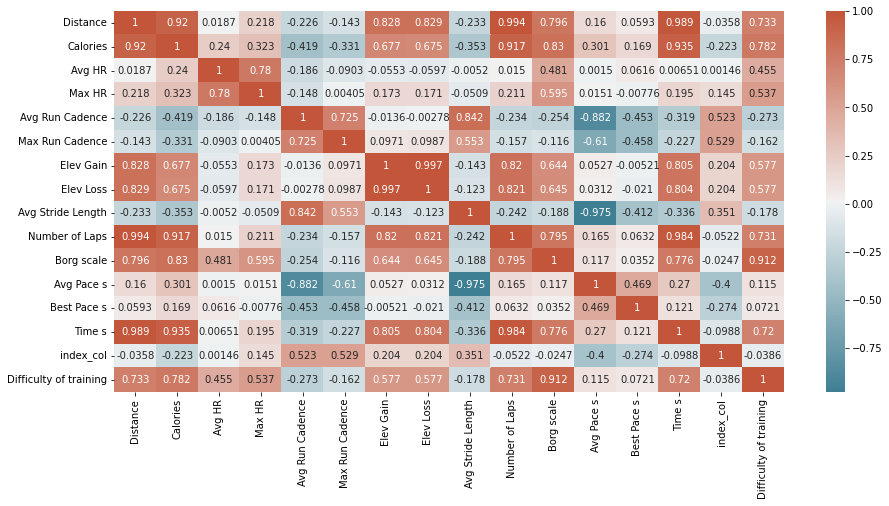

In [ ]:
corr = df.corr()
plt.figure(figsize=(15, 7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
annot=True, fmt='.3g', cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [ ]:
df = df.drop(['Activity Type','Title','Avg Run Cadence', 'Max Run Cadence', 'Avg Stride Length', 'Best Lap Time', 'Number of Laps'], axis=1)

In [ ]:
tired_list = []
list_tired = []
for i in df['index_col']:
  if len(tired_list) == 0:
    s = float(df['Borg scale'][i]) / 12 * float(df['Calories'][i])
    tired_list.append([df['Date'][i], s, s])
    list_tired.append(s)
  else:
    diff = df['Date'][i] - tired_list[len(tired_list)-1][0]
    if (diff.days < 7):
      diff_days = df['Date'][i] - tired_list[0][0]
      if (diff_days.days < 7):
        s = tired_list[len(tired_list)-1][1] + float(df['Borg scale'][i]) / 12 * float(df['Calories'][i])
        tired_list.append([df['Date'][i], s, float(df['Borg scale'][i]) / 12 * float(df['Calories'][i])])
        list_tired.append(s)
      elif (diff_days.days >= 7):
        s = tired_list[len(tired_list)-1][1] + float(df['Borg scale'][i]) / 12 * float(df['Calories'][i])
        while (diff_days.days >= 7):
          tmp = tired_list.pop(0)
          s = s - tmp[2]
          diff_days = df['Date'][i] - tired_list[0][0]
        tired_list.append([df['Date'][i], s, float(df['Borg scale'][i]) / 12 * float(df['Calories'][i])])
        list_tired.append(s)
    else:
      tired_list = []
      s = float(df['Borg scale'][i]) / 12 * float(df['Calories'][i])
      tired_list.append([df['Date'][i], s, s])
      list_tired.append(s)

df['General fatigue'] = list_tired
df = df.drop(['index_col'], axis=1)

In [ ]:
df = df.reset_index(drop=True)
df

,Date,Distance,Calories,Avg HR,Max HR,Elev Gain,Elev Loss,Borg scale,Avg Pace s,Best Pace s,Time s,Difficulty of training,General fatigue
0,2018-11-05,8.00,436,130,164,608,600,12.0,366,300,2931.0,3,436.000000
1,2018-11-06,1.89,125,130,150,81,115,9.0,404,289,763.0,2,529.750000
2,2018-11-06,1.30,71,137,156,53,59,9.0,299,275,389.4,2,583.000000
3,2018-11-06,1.28,86,155,188,33,43,11.0,305,292,392.3,2,661.833333
4,2018-11-06,1.29,96,172,186,34,40,11.0,304,289,392.2,2,749.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2020-07-11,5.19,419,129,143,76,80,9.0,481,408,2495.0,2,2295.666667
372,2020-07-12,7.01,633,142,157,215,219,12.0,453,300,3175.0,3,2768.666667
373,2020-07-13,5.01,392,128,151,124,124,9.0,485,349,2429.0,2,2565.833333
374,2020-07-14,6.50,587,144,160,183,187,11.0,434,395,2824.0,2,3103.916667


In [ ]:
fig = px.histogram(x=df['Difficulty of training'].values)
fig.show()

In [ ]:
for i in df:
  print(i)
  fig = px.box(y=df[i])
  fig.show()

Date


Distance


Calories


Avg HR


Max HR


Elev Gain


Elev Loss


Borg scale


Avg Pace s


Best Pace s


Time s


Difficulty of training


General fatigue


In [ ]:
upper_fence_dist = 11
df = df.loc[df['Distance'] <= upper_fence_dist]

upper_fence_time = 5191
df = df.loc[df['Time s'] <= 5191]

lower_fence_bestpaces = 115
df = df.loc[df['Best Pace s'] >= lower_fence_bestpaces]

upper_fence_avgpaces = 522
lower_fence_avgpaces = 334
df = df.loc[(df['Avg Pace s'] >= lower_fence_avgpaces) & (df['Avg Pace s'] <= upper_fence_avgpaces)]

lower_fence_avghr = 112
upper_fence_avghr = 177
df = df.loc[(df['Avg HR'] >= lower_fence_avghr) & (df['Avg HR'] <= upper_fence_avghr)]

lower_fence_maxhr = 123
upper_fence_maxhr = 201
df = df.loc[(df['Max HR'] >= lower_fence_maxhr) & (df['Max HR'] <= upper_fence_maxhr)] 

upper_fence_elvgain = 411
df = df.loc[df['Elev Gain'] <= upper_fence_elvgain]

upper_fence_elvloss = 416
df = df.loc[df['Elev Loss'] <= upper_fence_elvloss]

lower_fence_borg = 7
upper_fence_borg = 15
df = df.loc[(df['Borg scale'] >= lower_fence_borg) & (df['Borg scale'] <= upper_fence_borg)] 

df = df.reset_index(drop=True)

df

,Date,Distance,Calories,Avg HR,Max HR,Elev Gain,Elev Loss,Borg scale,Avg Pace s,Best Pace s,Time s,Difficulty of training,General fatigue
0,2018-11-06,1.89,125,130,150,81,115,9.0,404,289,763.0,2,529.750000
1,2018-11-13,2.05,127,127,143,51,142,8.0,411,306,843.0,1,1830.000000
2,2018-11-13,1.80,187,156,191,143,61,10.0,468,425,844.0,2,2265.833333
3,2018-11-19,7.44,520,139,165,191,209,12.0,421,354,3128.0,3,1040.500000
4,2018-11-20,6.94,457,135,182,126,128,11.0,408,348,2832.0,2,938.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2020-07-11,5.19,419,129,143,76,80,9.0,481,408,2495.0,2,2295.666667
252,2020-07-12,7.01,633,142,157,215,219,12.0,453,300,3175.0,3,2768.666667
253,2020-07-13,5.01,392,128,151,124,124,9.0,485,349,2429.0,2,2565.833333
254,2020-07-14,6.50,587,144,160,183,187,11.0,434,395,2824.0,2,3103.916667


# Обучение


CatBoost

In [ ]:
y = df['Borg scale']
X = df.drop(['Difficulty of training', 'Date', 'Borg scale'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = CatBoostRegressor(iterations=1000,
verbose=False,
loss_function='RMSE',
bootstrap_type='Bernoulli'
)

grid = {'learning_rate': [0.03, 1],
 'l2_leaf_reg': [0.5, 2, 5], 
 'max_depth': [6,12]}

grid_search_result = model.grid_search(grid,
 cv=10,
 verbose=False,
 X=X_train,
 y=y_train,
 plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.892020893
bestIteration = 241


bestTest = 1.815680848
bestIteration = 5


bestTest = 0.9247118436
bestIteration = 295


bestTest = 2.1162981
bestIteration = 7


bestTest = 0.9003206194
bestIteration = 410


bestTest = 2.038260664
bestIteration = 54


bestTest = 2.393126596
bestIteration = 573


bestTest = 4.087272407
bestIteration = 3


bestTest = 2.237585206
bestIteration = 970


bestTest = 4.089910896
bestIteration = 46


bestTest = 1.986063483
bestIteration = 999


bestTest = 3.190880519
bestIteration = 27

Training on fold [0/10]

bestTest = 0.7311740675
bestIteration = 999

Training on fold [1/10]

bestTest = 0.9955054911
bestIteration = 992

Training on fold [2/10]

bestTest = 0.6715675787
bestIteration = 996

Training on fold [3/10]

bestTest = 1.204844436
bestIteration = 983

Training on fold [4/10]

bestTest = 0.6770546487
bestIteration = 247

Training on fold [5/10]

bestTest = 1.182117496
bestIteration = 486

Training on fold [6/10]

bestTest = 1.65353093
best

In [ ]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03}

In [ ]:
model = CatBoostRegressor(
verbose=False,
loss_function='RMSE',
bootstrap_type='Bernoulli',
**grid_search_result['params']
)

model.fit(X_train, y_train)

In [ ]:
feature_importance = model.get_feature_importance()
top_5_features = pd.Series(feature_importance, index=X_test.columns).sort_values(ascending=False)
top_5_features = pd.DataFrame({'feature': top_5_features.index, 'importance': top_5_features.values})
fig = px.pie(top_5_features, values='importance', names='feature', title='Доля влияния признака на модель')
fig.show()

In [ ]:
predictions = model.predict(X_test)
predictions = [int(round(i, 0)) for i in predictions]

In [ ]:
precision = mae(y_test, predictions)
precision

0.4935064935064935

In [ ]:
def f(a):
    display(a)
    return a

In [ ]:
purpose = interactive(f, a=widgets.Combobox(options=["Легкие пробежки", "Поддержание формы", "Похудение", "Выработка общей выносливости"],  description="Основная цель тренировок: "))
display(purpose)

interactive(children=(Combobox(value='', description='Основная цель тренировок: ', options=('Легкие пробежки',…

In [ ]:
if (purpose.kwargs['a'] == "Легкие пробежки"):
    main_intensive_purpose = 1
elif (purpose.kwargs['a'] == "Поддержание формы"):
    main_intensive_purpose = 2
elif (purpose.kwargs['a'] == "Похудение"):
    main_intensive_purpose = 3
elif (purpose.kwargs['a'] == "Выработка общей выносливости"):
    main_intensive_purpose = 4

In [ ]:
print("Введите дату тренировки:")
print("\n")
day_train = interactive(f, a=widgets.FloatSlider(min=1, max=31, step=1, value=1, description='День: '))
display(day_train)

print("\n")
month_train = interactive(f, a=widgets.FloatSlider(min=1, max=12, step=1, value=1, description='Месяц: '))
display(month_train)

print("\n")
year_train = interactive(f, a=widgets.FloatSlider(min=2020, max=2025, step=1, value=2020, description='Год: '))
display(year_train)

Введите дату тренировки:




interactive(children=(FloatSlider(value=1.0, description='День: ', max=31.0, min=1.0, step=1.0), Output()), _d…

interactive(children=(FloatSlider(value=1.0, description='Месяц: ', max=12.0, min=1.0, step=1.0), Output()), _…

interactive(children=(FloatSlider(value=2020.0, description='Год: ', max=2025.0, min=2020.0, step=1.0), Output…

In [ ]:
print("Введите ваш вес:")
agent_weight = interactive(f, a=widgets.FloatSlider(min=40, max=250, step=1, value=73))
display(agent_weight)

print("\n\nВведите тренировочную дистанцию:")
distance = interactive(f, a=widgets.FloatSlider(min=0.5, max=50, step=0.5, value=6))
display(distance)

print("\n\nВведите предполагаемое время тренировки (в минутах):")
time = interactive(f, a=widgets.FloatSlider(min=1, max=500, step=0.5, value=36))
display(time)

print("\n\nВведите максимально допустимый темп тренировки (в минутах):")
best_pace = interactive(f, a=widgets.FloatSlider(min=2, max=8, step=0.5, value=4.5))
display(best_pace)

print("\n\nВведите средний показатель ЧСС, на который будете ориентироваться во время тренировки:")
average_hr = interactive(f, a=widgets.FloatSlider(min=100, max=180, step=5, value=140))
display(average_hr)

print("\n\nВведите максимально допустимый показатель ЧСС во время тренировки:")
m_hr = interactive(f, a=widgets.FloatSlider(min=130, max=190, step=10, value=170))
display(m_hr)

print("\n\nВведите Elev Gain")
elev_gain = interactive(f, a=widgets.FloatSlider(min=0, max=1000, step=20, value=120))
display(elev_gain)

print("\n\nВведите Elev Loss")
elev_loss = interactive(f, a=widgets.FloatSlider(min=5, max=1005, step=20, value=125))
display(elev_loss)

Введите ваш вес:


interactive(children=(FloatSlider(value=73.0, description='a', max=250.0, min=40.0, step=1.0), Output()), _dom…



Введите тренировочную дистанцию:


interactive(children=(FloatSlider(value=6.0, description='a', max=50.0, min=0.5, step=0.5), Output()), _dom_cl…



Введите предполагаемое время тренировки (в минутах):


interactive(children=(FloatSlider(value=36.0, description='a', max=500.0, min=1.0, step=0.5), Output()), _dom_…



Введите максимально допустимый темп тренировки (в минутах):


interactive(children=(FloatSlider(value=4.5, description='a', max=8.0, min=2.0, step=0.5), Output()), _dom_cla…



Введите средний показатель ЧСС, на который будете ориентироваться во время тренировки:


interactive(children=(FloatSlider(value=140.0, description='a', max=180.0, min=100.0, step=5.0), Output()), _d…



Введите максимально допустимый показатель ЧСС во время тренировки:


interactive(children=(FloatSlider(value=170.0, description='a', max=190.0, min=130.0, step=10.0), Output()), _…



Введите Elev Gain


interactive(children=(FloatSlider(value=120.0, description='a', max=1000.0, step=20.0), Output()), _dom_classe…



Введите Elev Loss


interactive(children=(FloatSlider(value=125.0, description='a', max=1005.0, min=5.0, step=20.0), Output()), _d…

In [ ]:
day = int(day_train.kwargs['a'])
month = int(month_train.kwargs['a'])
year = int(year_train.kwargs['a'])

weight = agent_weight.kwargs['a']
dist = distance.kwargs['a']
time_train = time.kwargs['a'] * 60
bst_pace = best_pace.kwargs['a'] * 60
avg_hr = average_hr.kwargs['a']
max_hr = m_hr.kwargs['a']
elv_gain = elev_gain.kwargs['a']
elv_loss = elev_loss.kwargs['a']
calories = 0.014 * weight * (time_train / 60) * (0.12 * avg_hr - 7)
avg_pace = time_train / dist

# general_fatigue = df['General fatigue'][0]
#general_fatigue = 250

date = datetime.date(year, month, day)
diff = date - df['Date'][len(df)-1]
if (diff.days >= 7):
  general_fatigue = calories
else:
  i = len(df) - 1
  while (diff.days < 7):
    i = i - 1
    diff = date - df['Date'][i]
  general_fatigue = calories + df['General fatigue'][len(df)-1] - (df['Borg scale'][i] / 12) * df['Calories'][i]

In [ ]:
train = [dist, calories, avg_hr, max_hr, elv_gain, elv_loss, avg_pace, bst_pace, time_train, general_fatigue]

In [ ]:
borg_scale = int(round(model.predict([train])[0],0))
print("Предполагаемая оценка (по шкале Борга) следующей тренировки: " + str(borg_scale))

Предполагаемая оценка (по шкале Борга) следующей тренировки: 14


In [ ]:
general_fatigue += (borg_scale / 12 - 1) * calories
if (general_fatigue > main_intensive_purpose * 1400):
  print("Рекомендуем Вам сделать отдых, либо выполнить более легкую тренировку")
elif (general_fatigue < (main_intensive_purpose - 1) * 1400):
  print("Рекомендуем Вам усложнить тренировку")
else:
  print("Данная тренировка оптимальная в Вашем тренировочном плане")

Данная тренировка оптимальная в Вашем тренировочном плане


# Внесем прошедшую тренировку в датасет

In [ ]:
print("Совпала ли Ваша оценка по шкале Борга после проведенной тренировки с предсказанной?")
condition = interactive(f, a=widgets.Combobox(options=["Да", "Нет"],  description="Совпала? "))
display(condition)

print("Если не совпала, то укажите получившуюся оценку")
bborg_scale = interactive(f, a=widgets.IntSlider(min=6, max=20, step=1, value=borg_scale))
display(bborg_scale)

Совпала ли Ваша оценка по шкале Борга после проведенной тренировки с предсказанной?


interactive(children=(Combobox(value='', description='Совпала? ', options=('Да', 'Нет')), Output()), _dom_clas…

Если не совпала, то укажите получившуюся оценку


interactive(children=(IntSlider(value=14, description='a', max=20, min=6), Output()), _dom_classes=('widget-in…

In [ ]:
if (condition.kwargs['a'] == "Нет"):
  general_fatigue = general_fatigue - (borg_scale / 12 - 1) * calories
  borg_scale = bborg_scale.kwargs['a']
  general_fatigue += (borg_scale / 12 - 1) * calories

if (borg_scale >=6 and borg_scale <= 8):
  hardly_train = 1
elif (borg_scale >=9 and borg_scale <= 11):
  hardly_train = 2
elif (borg_scale >= 12 and borg_scale <= 15):
  hardly_train = 3
else:
  hardly_train = 4

new_train = [date, dist, calories, avg_hr, max_hr, elv_gain, elv_loss, borg_scale, avg_pace, bst_pace, time_train, hardly_train, general_fatigue]
new_df_row = pd.DataFrame([new_train], columns=['Date',	'Distance',	'Calories',	'Avg HR',	'Max HR', 'Elev Gain', 'Elev Loss',	'Borg scale',	'Avg Pace s',	'Best Pace s',	'Time s',	'Difficulty of training',	'General fatigue'])
df = df.append(new_df_row, ignore_index=True)
df

,Date,Distance,Calories,Avg HR,Max HR,Elev Gain,Elev Loss,Borg scale,Avg Pace s,Best Pace s,Time s,Difficulty of training,General fatigue
0,2018-11-06,1.89,125.0000,130.0,150.0,81.0,115.0,9.0,404.0,289.0,763.0,2,529.750000
1,2018-11-13,2.05,127.0000,127.0,143.0,51.0,142.0,8.0,411.0,306.0,843.0,1,1830.000000
2,2018-11-13,1.80,187.0000,156.0,191.0,143.0,61.0,10.0,468.0,425.0,844.0,2,2265.833333
3,2018-11-19,7.44,520.0000,139.0,165.0,191.0,209.0,12.0,421.0,354.0,3128.0,3,1040.500000
4,2018-11-20,6.94,457.0000,135.0,182.0,126.0,128.0,11.0,408.0,348.0,2832.0,2,938.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2020-07-12,7.01,633.0000,142.0,157.0,215.0,219.0,12.0,453.0,300.0,3175.0,3,2768.666667
253,2020-07-13,5.01,392.0000,128.0,151.0,124.0,124.0,9.0,485.0,349.0,2429.0,2,2565.833333
254,2020-07-14,6.50,587.0000,144.0,160.0,183.0,187.0,11.0,434.0,395.0,2824.0,2,3103.916667
255,2020-07-15,6.00,530.0000,141.0,160.0,169.0,173.0,11.0,439.0,380.0,2635.0,2,3169.916667


In [ ]:
date = df['Date'][len(df)-1]
mm = ['Distance', 'Calories', 'Avg HR', 'Borg scale']
for i in mm:
  j = len(df)-1
  list_for_graph = [df[i][j]]
  while ((date - df['Date'][j-1]).days < 7):
    j = j - 1
    list_for_graph.insert(0, df[i][j])
  print("График для " + i)
  fig = px.bar(y=list_for_graph)
  fig.show()

График для Distance


График для Calories


График для Avg HR


График для Borg scale
